In [16]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

%matplotlib inline

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

### Visualize some example image

In [23]:
landmarks_frame = pd.read_csv('faces/face_landmarks.csv')

n = 55
img_name = landmarks_frame.iloc[n, 0]
landmarks = landmarks_frame.iloc[n, 1:].as_matrix()
landmarks = landmarks.astype('float').reshape(-1, 2)

print('image name: ', img_name)
print('landmarks shape: ', landmarks.shape)
print('first 4 landmarks: ', landmarks[:4])

image name:  3872768751_e60d7fdbd5.jpg
landmarks shape:  (68, 2)
first 4 landmarks:  [[268. 110.]
 [271. 124.]
 [277. 136.]
 [283. 148.]]


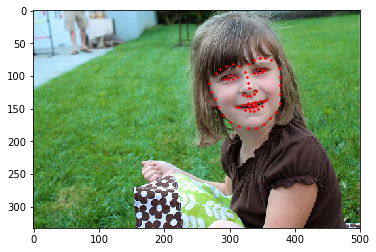

In [24]:
def show_landmarks(image, landmarks):
    '''show image with landmarks'''
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)

plt.figure()
show_landmarks(io.imread(os.path.join('faces/', img_name)), landmarks)
plt.show()

### Create a Dataset class

In [52]:
class FaceLandmarksDataset(Dataset):
    
    
    def __init__(self, csv_file, root_dir, transform=None):
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.landmarks_frame)
    
    def __getitem__(self, idx):
        image_name = self.landmarks_frame.iloc[idx, 0]
        image = io.imread(os.path.join(self.root_dir, image_name))
        
        landmarks = self.landmarks_frame.iloc[idx, 1:].as_matrix()
        landmarks = landmarks.astype('float').reshape(-1, 2)

        sample = {'image': image, 'landmarks': landmarks}
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample

image shape: (324, 215, 3), landmark shape: (68, 2)
image shape: (500, 333, 3), landmark shape: (68, 2)
image shape: (250, 258, 3), landmark shape: (68, 2)
image shape: (434, 290, 3), landmark shape: (68, 2)
image shape: (828, 630, 3), landmark shape: (68, 2)
image shape: (402, 500, 3), landmark shape: (68, 2)
image shape: (332, 500, 3), landmark shape: (68, 2)
image shape: (333, 500, 3), landmark shape: (68, 2)


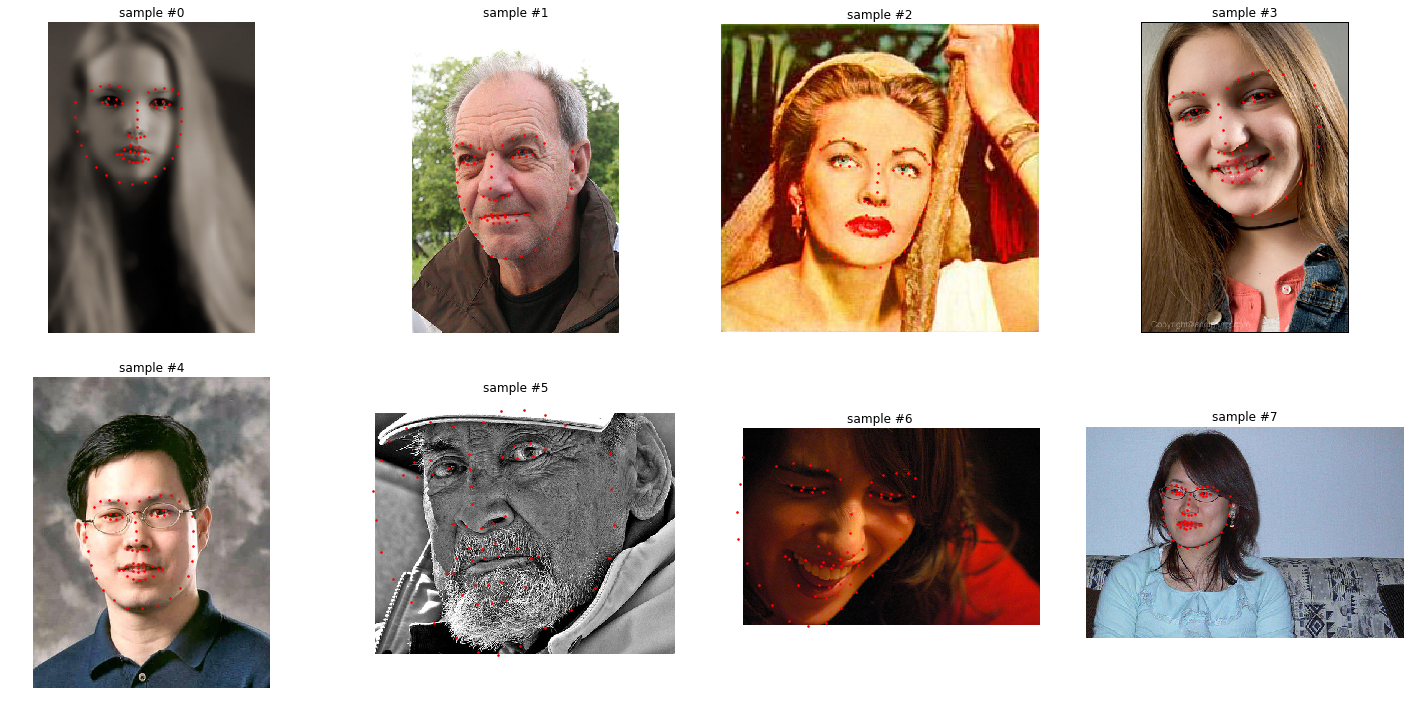

In [53]:
face_dataset = FaceLandmarksDataset(csv_file='faces/face_landmarks.csv', root_dir='faces/')

fig = plt.figure(figsize=(20, 10))

for i in range(len(face_dataset)):
    sample = face_dataset[i]
    
    print('image shape: {}, landmark shape: {}'.format(sample['image'].shape, sample['landmarks'].shape))
    
    ax = plt.subplot(2, 4, i+1)
    plt.tight_layout()
    ax.set_title('sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample) # This little trick!
    
    if i == 7:
        plt.show()
        break

### Define transforms as classes

In [126]:
class Rescale(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple)) # This little trick!
        self.output_size = output_size
        
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_w = self.output_size
                new_h = new_w * h / w
            else:
                new_h = self.output_size
                new_w = new_h * w / h
        else:
            new_h, new_w = self.output_size
        
        new_h, new_w = int(new_h), int(new_w)
        
        image = transform.resize(image, (new_h, new_w))
        
        landmarks = landmarks * [new_w/w, new_h/h] # cannot be wrtten as landmarks *= [new_w/w, new_h/h]
        
        return {'image': image, 'landmarks': landmarks}

In [127]:
class RandomCrop(object):
    
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            self.output_size = output_size
            
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        
        h, w = image.shape[:2]
        new_h, new_w = self.output_size
        
        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)
        
        image = image[top: top + new_h, left: left + new_w]
        
        landmarks = landmarks - [left, top]
        
        return {'image': image, 'landmarks': landmarks}

In [128]:
class ToTensor(object):
    
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        
        image = image.transpose(2, 0, 1)
        
        return {'image': torch.from_numpy(image), 'landmarks': torch.from_numpy(landmarks)}

### Compose transforms

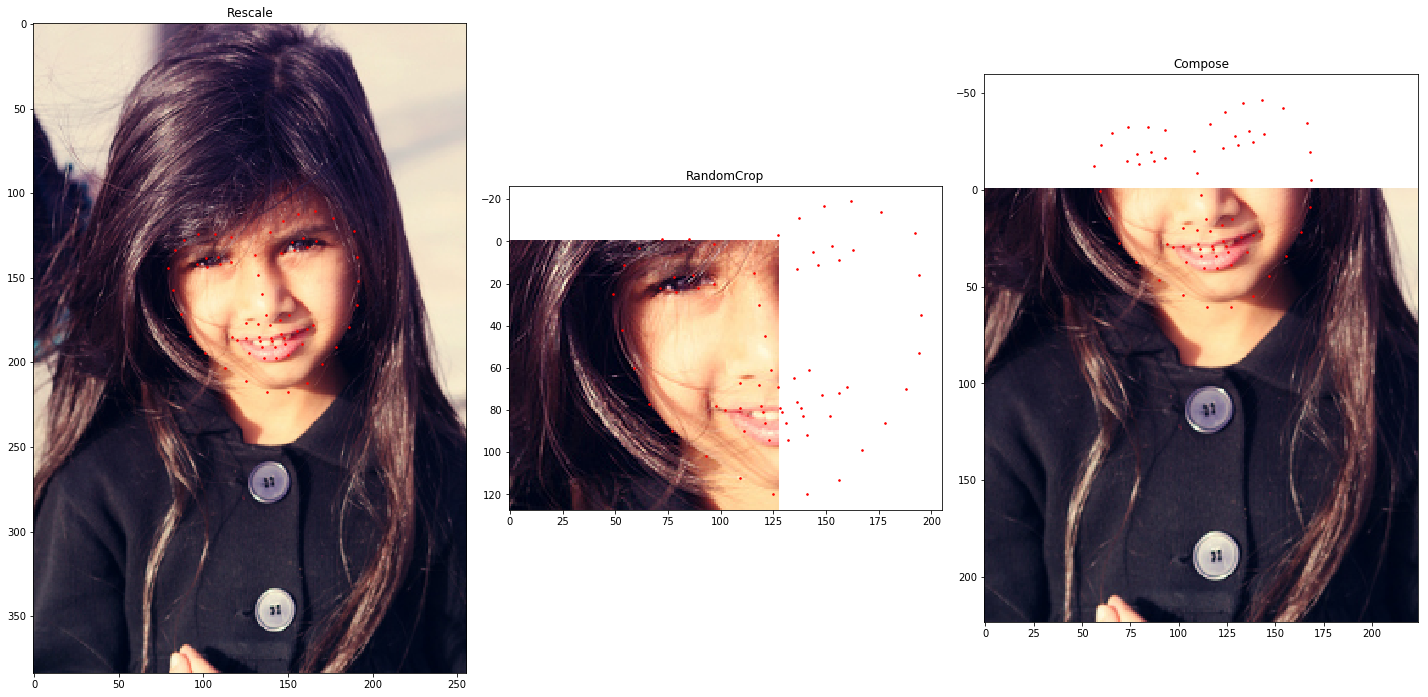

In [125]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256), RandomCrop(224)])

fig = plt.figure(figsize=(20, 10))
sample = face_dataset[49]

for i, tsfrm in enumerate([scale, crop, composed]):

    transformed_sample = tsfrm(sample)
    
    ax = plt.subplot(1, 3, i+1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)

plt.show()

### Iterating through the dataset

In [129]:
transformed_dataset = FaceLandmarksDataset(csv_file='faces/face_landmarks.csv', 
                                           root_dir='faces/', 
                                           transform=transforms.Compose([Rescale(256), 
                                                                         RandomCrop(224), 
                                                                         ToTensor()]))
for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]
    
    print(i, sample['image'].size(), sample['landmarks'].size())
    
    if i == 3:
        break

0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])


### Don' t miss
- batching the data
- shuffling the data
- load the data in parallel using multiprocessing workers

All above features are provided by DataLoader

0 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])


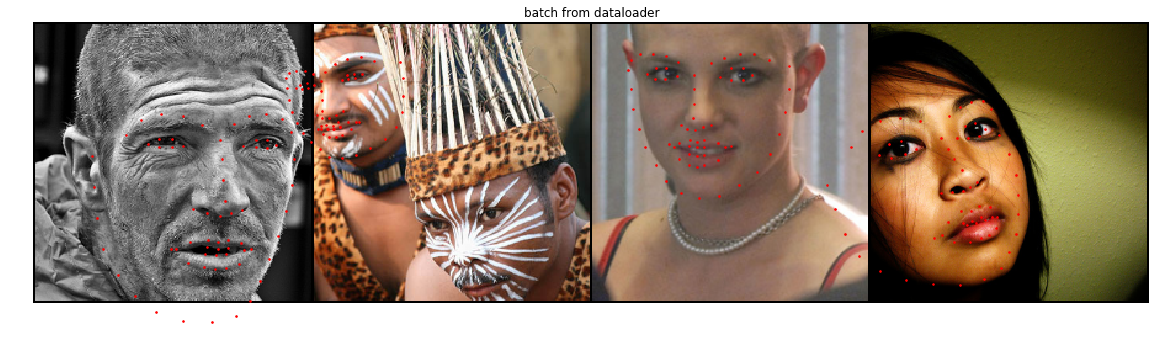

In [140]:
dataloader = DataLoader(transformed_dataset, batch_size=4, shuffle=True, num_workers=4)

# helper function to show a batch
def show_landmarks_batch(sampled_batch):
    images_batch, landmarks_batch = sampled_batch['image'], sampled_batch['landmarks']
    
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    
    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    
    for i in range(batch_size):
        
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size,
                    landmarks_batch[i, :, 1].numpy(), s=10, marker='.', c='r')
        plt.title('batch from dataloader')

for i_batch, sampled_batch in enumerate(dataloader):
    print(i_batch, sampled_batch['image'].size(), sampled_batch['landmarks'].size())
    
    if i_batch == 3:
        plt.figure(figsize=(20, 10))
        show_landmarks_batch(sampled_batch)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break